# Trumpfselektion with Deep NN Baseline

Based on script by Thomas Koller 01.10.19

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
import itertools
datafile = 'data/jass/rnd_01.csv'
col_names = [a+str(b) for (a,b) in itertools.product([farbe for farbe in 'HKSE'], [bild for bild in range(9)])]+["Geschoben", "Player", "Aktion"]
data = pd.read_csv(datafile, header=None, names=col_names)
data

,H0,H1,H2,H3,H4,H5,H6,H7,H8,K0,...,E2,E3,E4,E5,E6,E7,E8,Geschoben,Player,Aktion
0,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,1631,2
1,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,64310,6
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,16721,1
3,1,0,0,0,1,0,0,0,1,1,...,0,0,1,0,1,0,0,1,0,4
4,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,72620,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161689,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,55942,3
161690,0,0,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,6
161691,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,0,3
161692,0,1,0,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,60659,6


## Binary Classification on targets 0 and 1

In [3]:
# select subset of data
target_classes = [0,1]
num_classes = len(target_classes)
zeroone = data[data['Aktion'].isin(target_classes)]
zeroone = zeroone.drop(columns='Player')
X = zeroone.loc[:,'H0':'Geschoben'].values.astype(np.float32)
y = zeroone.loc[:,'Aktion']

# make sure targets are binary (required by GPC implementation of sklearn)
y = y.isin(target_classes[0:1]) # first class = 1, second = 0
y = y.values
y = keras.utils.to_categorical(y, num_classes=num_classes)

In [4]:
def crossvalidate(build_fn, batch_size, epochs, train_size, test_size, folds):
    np.random.seed(23)
    tf.set_random_seed(23)
    hists = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[]}
    for f in range(folds):
        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size, test_size=test_size, random_state=f)
        model = build_fn()
        hist = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=epochs, batch_size=batch_size, verbose=False, shuffle=True)
        for k, v in hist.history.items():
            hists[k] += [v]
    return hists
    
def print_crossvalidated_results(hists):
    acc_mean = np.mean(hists['acc'],axis=0)[-1]
    acc_std = np.std(hists['acc'],axis=0)[-1]
    val_acc_mean = np.mean(hists['val_acc'],axis=0)[-1]
    val_acc_std = np.std(hists['val_acc'],axis=0)[-1]
    print('Accuracy: \n  train %.3f (%.3f-%.3f)\n  val   %.3f (%.3f-%.3f)' % (acc_mean, acc_mean-2*acc_std, acc_mean+2*acc_std, val_acc_mean, val_acc_mean-2*val_acc_std, val_acc_mean+2*val_acc_std))
    fig, ax = plt.subplots(1,2, figsize=(15,3))
    fig.suptitle('Learning Curves of last run')
    ax[0].plot(hists['loss'][-1], label='train')
    ax[0].plot(hists['val_loss'][-1], label='val')
    ax[0].set_title('loss')
    ax[0].legend()
    ax[1].plot(hists['acc'][-1], label='train')
    ax[1].plot(hists['val_acc'][-1], label='val')
    ax[1].set_title('accuracy')
    ax[1].legend();

In [5]:
import pathlib
def save_hists(name, hists, path='./metrics/06_Jass_NN_binary/'):
    file = pathlib.Path(path+name)
    if file.exists():
        file.unlink()
    np.savez(file, **hists)
def load_hists(name, path='./metrics/06_Jass_NN_binary/'):
    file = pathlib.Path(path+name+str('.npz'))
    container = np.load(file)
    return {key:value for (key, value) in container.items()}

### Baseline (Logistic Regression)

Binary classification problem is almost linearly separable. We reach an accuracy of ~94% with 500 training samples only.

In [6]:
def linear_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(2, activation='softmax', input_shape=[37]))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Accuracy: 
  train 0.967 (0.946-0.988)
  val   0.941 (0.929-0.954)
CPU times: user 2min 57s, sys: 5.89 s, total: 3min 3s
Wall time: 5min 45s


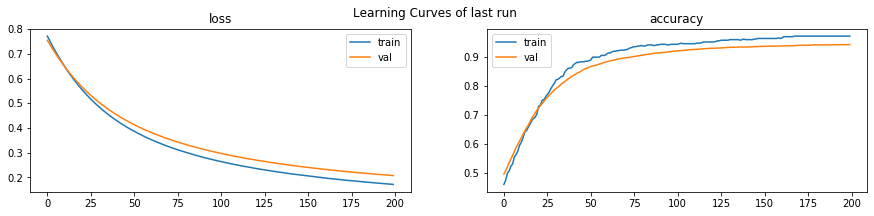

In [7]:
%%time
epochs = 200
batch_size = 64
hists_0_500 = crossvalidate(linear_model, batch_size, epochs, 500, 10000, 5)
save_hists('hists_0_500', hists_0_500)
print_crossvalidated_results(hists_0_500)

Accuracy: 
  train 0.962 (0.954-0.970)
  val   0.952 (0.948-0.956)
CPU times: user 1min 57s, sys: 3.72 s, total: 2min 1s
Wall time: 3min 45s


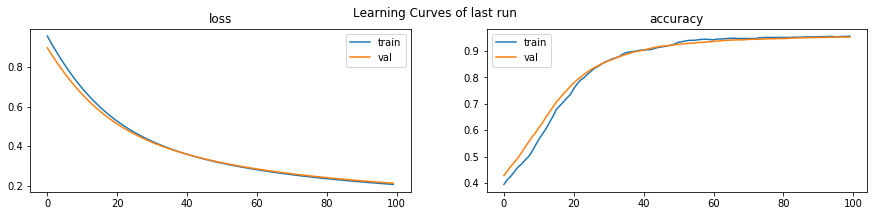

In [8]:
%%time
epochs = 100
batch_size = 64
hists_0_1000 = crossvalidate(linear_model, batch_size, epochs, 1000, 10000, 5)
save_hists('hists_0_1000', hists_0_1000)
print_crossvalidated_results(hists_0_1000)

Accuracy: 
  train 0.966 (0.964-0.968)
  val   0.964 (0.961-0.966)
CPU times: user 47.7 s, sys: 1.21 s, total: 48.9 s
Wall time: 1min 25s


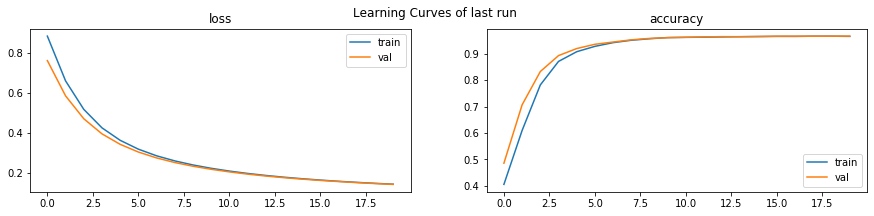

In [9]:
%%time
epochs = 20
batch_size = 64
hists_0_10000 = crossvalidate(linear_model, batch_size, epochs, 10000, 10000, 5)
save_hists('hists_0_10000', hists_0_10000)
print_crossvalidated_results(hists_0_10000)

### Deep model (h=4)

Using one hidden layer does not improve the val-accuracy. But it leads to slightly moreoverfitting for small datasets...

In [10]:
def deep_model_h4():
    model = keras.Sequential()
    model.add(keras.layers.Dense(4, activation='relu', input_shape=[37]))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Accuracy: 
  train 0.980 (0.968-0.993)
  val   0.949 (0.940-0.957)
CPU times: user 2min 20s, sys: 3.5 s, total: 2min 24s
Wall time: 4min 26s


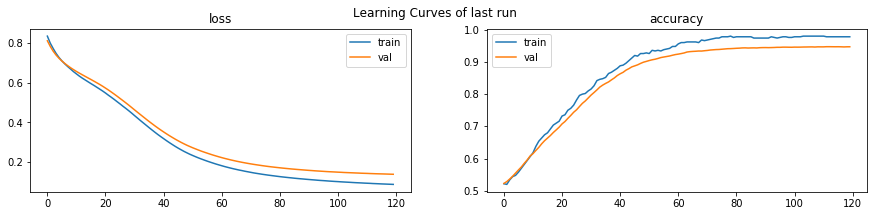

In [11]:
%%time
epochs = 120
batch_size = 64
hists_4_500 = crossvalidate(deep_model_h4, batch_size, epochs, 500, 10000, 5)
save_hists('hists_4_500', hists_4_500)
print_crossvalidated_results(hists_4_500)

Accuracy: 
  train 0.970 (0.959-0.981)
  val   0.956 (0.950-0.962)
CPU times: user 1min 42s, sys: 2.32 s, total: 1min 45s
Wall time: 3min 14s


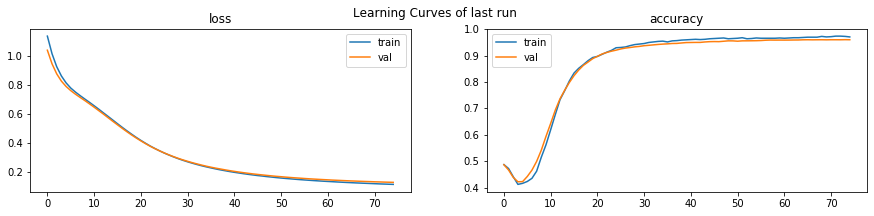

In [12]:
%%time
epochs = 75
batch_size = 64
hists_4_1000 = crossvalidate(deep_model_h4, batch_size, epochs, 1000, 10000, 5)
save_hists('hists_4_1000', hists_4_1000)
print_crossvalidated_results(hists_4_1000)

Accuracy: 
  train 0.966 (0.963-0.968)
  val   0.964 (0.961-0.967)
CPU times: user 36.9 s, sys: 460 ms, total: 37.3 s
Wall time: 1min 9s


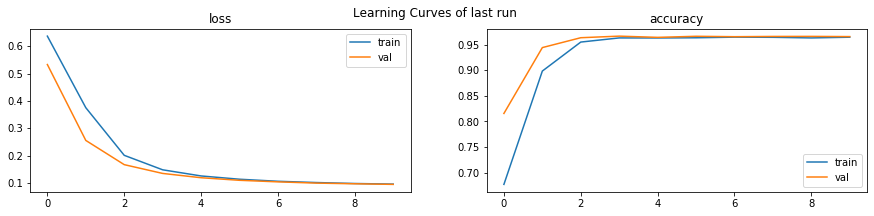

In [13]:
%%time
epochs = 10
batch_size = 64
hists_4_10000 = crossvalidate(deep_model_h4, batch_size, epochs, 10000, 10000, 5)
save_hists('hists_4_10000', hists_4_10000)
print_crossvalidated_results(hists_4_10000)

### Deep model (h=16)

Increasing the hidden layer does not improve the val-accuracy neither. Even more overfitting for small datasets

In [14]:
def deep_model_h16():
    model = keras.Sequential()
    model.add(keras.layers.Dense(16, activation='relu', input_shape=[37]))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Accuracy: 
  train 0.992 (0.987-0.998)
  val   0.949 (0.942-0.956)
CPU times: user 2min, sys: 5.78 s, total: 2min 6s
Wall time: 2min 47s


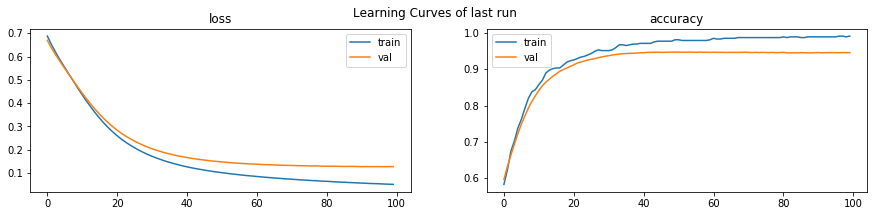

In [15]:
%%time
epochs = 100
batch_size = 64
hists_16_500 = crossvalidate(deep_model_h16, batch_size, epochs, 500, 10000, 5)
save_hists('hists_16_500', hists_16_500)
print_crossvalidated_results(hists_16_500)

Accuracy: 
  train 0.979 (0.971-0.987)
  val   0.956 (0.953-0.959)
CPU times: user 59.7 s, sys: 3.74 s, total: 1min 3s
Wall time: 57.4 s


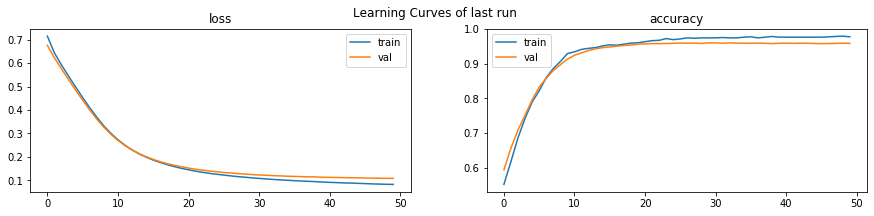

In [16]:
%%time
epochs = 50
batch_size = 64
hists_16_1000 = crossvalidate(deep_model_h16, batch_size, epochs, 1000, 10000, 5)
save_hists('hists_16_1000', hists_16_1000)
print_crossvalidated_results(hists_16_1000)

Accuracy: 
  train 0.966 (0.964-0.968)
  val   0.964 (0.960-0.968)
CPU times: user 31.8 s, sys: 1.69 s, total: 33.5 s
Wall time: 30.4 s


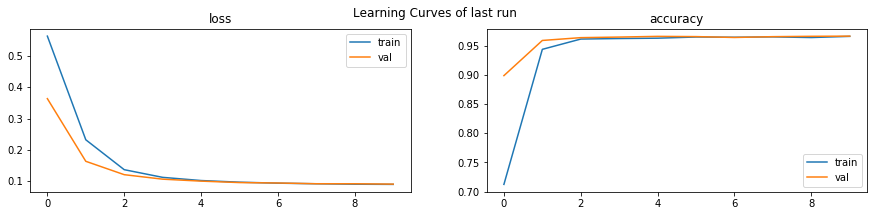

In [17]:
%%time
epochs = 10
batch_size = 64
hists_16_10000 = crossvalidate(deep_model_h16, batch_size, epochs, 10000, 10000, 5)
save_hists('hists_16_10000', hists_16_10000)
print_crossvalidated_results(hists_16_10000)

## Load and plot results

In [75]:
x_ticks = [0,1,2,5,6,7,10,11,12]
all_hists_names = ['hists_0_500', 'hists_0_1000', 'hists_0_10000', 'hists_4_500', 'hists_4_1000', 'hists_4_10000', 'hists_16_500', 'hists_16_1000', 'hists_16_10000']
all_hists = [load_hists(name) for name in all_hists_names]
test_acc_mean = [np.mean(h['val_acc'],axis=0)[-1] for h in all_hists]
test_acc_std = [np.std(h['val_acc'],axis=0)[-1]*1.282 for h in all_hists]
train_acc_mean = [np.mean(h['acc'],axis=0)[-1] for h in all_hists]
train_acc_std = [np.std(h['acc'],axis=0)[-1]*1.282 for h in all_hists]
train_sizes = ['500','1K','10K']
labels = ['Linear '+s for s in train_sizes]+['MLP4 '+s for s in train_sizes]+['MLP16 '+s for s in train_sizes]

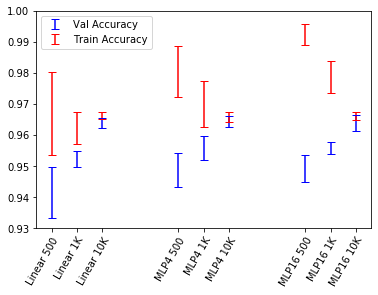

In [76]:
plt.figure(figsize=(6,4))
plt.errorbar(x_ticks,test_acc_mean,yerr=test_acc_std, markersize=0, capsize=4, ecolor='b', fmt='b.', label='Val Accuracy')
plt.errorbar(x_ticks,train_acc_mean,yerr=train_acc_std, markersize=0, capsize=4, ecolor='r', fmt='b.', label='Train Accuracy')
plt.xticks(x_ticks, labels=labels,rotation=60, ha='right', rotation_mode="anchor");
plt.ylim(0.93, 1)
plt.legend(loc='upper left');

## Load and plot results - combined with GP results

### metrics from 06_Jass_GPy_binary.ipynb are loaded. For report only!

In [90]:
import pickle
def load_metrics(name, path='./metrics/06_Jass_GP_binary/'):
    return pickle.load(open(path+name, 'rb'))

gp_filenames = ['0'+str(i+1) for i in range(4)]
all_mets = [load_metrics(name) for name in gp_filenames]
test_acc_mean_gp = [np.mean(h['acc_val'],axis=0) for h in all_mets]
test_acc_std_gp = [np.std(h['acc_val'],axis=0)*1.282 for h in all_mets]
train_acc_mean_gp = [np.mean(h['acc'],axis=0) for h in all_mets]
train_acc_std_gp = [np.std(h['acc'],axis=0)*1.282 for h in all_mets]

x_ticks = [0,1,2,5,6,7,10,11,12,15,16,17,18]
all_hists_names = ['hists_0_500', 'hists_0_1000', 'hists_0_10000', 'hists_4_500', 'hists_4_1000', 'hists_4_10000', 'hists_16_500', 'hists_16_1000', 'hists_16_10000']
all_hists = [load_hists(name) for name in all_hists_names]
test_acc_mean = [np.mean(h['val_acc'],axis=0)[-1] for h in all_hists]+test_acc_mean_gp
test_acc_std = [np.std(h['val_acc'],axis=0)[-1]*1.282 for h in all_hists]+test_acc_std_gp
train_acc_mean = [np.mean(h['acc'],axis=0)[-1] for h in all_hists]+train_acc_mean_gp
train_acc_std = [np.std(h['acc'],axis=0)[-1]*1.282 for h in all_hists]+train_acc_std_gp
train_sizes = ['500','1K','10K']
labels = ['Linear '+s for s in train_sizes]+['MLP4 '+s for s in train_sizes]+['MLP16 '+s for s in train_sizes]



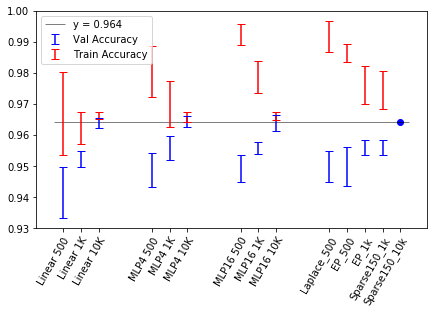

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.hlines(0.964,-0.5,19.5,linewidth=1,color=[0,0,0,0.5], label='y = 0.964')
plt.errorbar(x_ticks,test_acc_mean,yerr=test_acc_std, markersize=0, capsize=4, ecolor='b', fmt='b.', label='Val Accuracy')
plt.errorbar(x_ticks,train_acc_mean,yerr=train_acc_std, markersize=0, capsize=4, ecolor='r', fmt='b.', label='Train Accuracy')
plt.scatter(19, 0.964, c='b')
plt.xticks(x_ticks+[19], labels=labels+['Laplace_500', 'EP_500', 'EP_1k', 'Sparse150_1k', 'Sparse150_10k'], rotation=60, ha='right', rotation_mode="anchor");
plt.ylim(0.93, 1)
plt.legend();